# Simple example

To illustrate the basic functionallity, we'll fit the eight schools model (the "hello world" of bayesian models).

We begin by importing the Stan2tfp object, and plotting functionality:

In [1]:
from stan2tfp import Stan2tfp
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

The model itself is written in Stan, and is specified as a multiline string: 

In [2]:
stan_code = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  vector[J] theta_tilde;
}

transformed parameters {
  vector[J] theta = mu + tau * theta_tilde;
}

model {
  mu ~ normal(0, 5);
  tau ~ normal(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

The data is specified using a dictionary:

In [3]:
eight_schools_data_dict = dict(
    J=8,
    y=[28, 8, -3, 7, -1, 1, 18, 12],
    sigma=[15, 10, 16, 11, 9, 11, 10, 18]
)

Finally, the model object itself is created: 

In [4]:
model = Stan2tfp(stan_model_code=stan_code, data_dict=eight_schools_data_dict)

Download complete, saved to: /Users/adamhaber/projects/stan2tfp/stan2tfp/stan2tfp_compiler.exe
Compiling stan file to tfp file...


We can also instantiate the model using an external `.stan` file. Passing the data dict at this point is not necessary, as it's not needed for the tranlation of Stan code; we could've used:

In [5]:
model = Stan2tfp(stan_model_code=stan_code);
# # do whatever you want here
model.init_model(data_dict=eight_schools_data_dict)

Compiling stan file to tfp file...


... instead.

Note that since this is the first time we're calling the compiler, `stan2tfp` automatically downloads the latest pre-compiled binary, and informs you about its path.

To inspect the emitted TFP code, call `get_tfp_code()`:

In [6]:
print(model.get_tfp_code())


import numpy as np__
import tensorflow as tf__
import tensorflow_probability as tfp__
tfd__ = tfp__.distributions
tfb__ = tfp__.bijectors
from tensorflow.python.ops.parallel_for import pfor as pfor__

class nameuwktdqn_model(tfd__.Distribution):

  def __init__(self, J, y, sigma):
    self.J = J
    self.y = tf__.cast(y, tf__.float64)
    self.sigma = tf__.cast(sigma, tf__.float64)
    
     
  
  def log_prob_one_chain(self, params):
    target = 0
    
    # Data
    J = self.J
    y = self.y
    sigma = self.sigma
    
    # Transformed data
    
    
    # Parameters
    mu = tf__.cast(params[0], tf__.float64)
    tau = tf__.cast(params[1], tf__.float64)
    theta_tilde = tf__.cast(params[2], tf__.float64)
    
    # Target log probability computation
    theta = mu + (tau * theta_tilde)
    target += tf__.reduce_sum(tfd__.Normal(tf__.cast(0, tf__.float64),
                                           tf__.cast(5, tf__.float64)).log_prob(mu))
    target += tf__.reduce_sum(tfd__.Norm

Internally, this code is now `eval`ed by the interpreter and creates the necessary _python_ objects in the current namespace.

To fit the model, we call the `sample` method; it's a wrapper around TFP's MCMC machinery, aiming for sensible defaults and ease-of-use:

In [7]:
mcmc_trace, kernel_results = model.sample()

`model.sample` returns the actual samples (`mcmc_trace`) and TFP's `kernel_results` (holding important sampler diagnostics). Since we're in TFP-world now, we can use any tool from the TFP ecosystem we like; specifically, we can use the excellent [Arviz](https://arviz-devs.github.io) library for plotting: 

In [8]:
data_for_az = az.from_tfp(posterior=mcmc_trace, var_names=['mu','trace','theta_tilde'])

/Users/adamhaber/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
W0517 15:31:11.815162 4598851008 deprecation.py:323] From /Users/adamhaber/miniconda3/envs/stan2tfp-dev/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
data_for_az.posterior

<xarray.Dataset>
Dimensions:            (chain: 1, draw: 1000, mu_dim_0: 4, theta_tilde_dim_0: 4, theta_tilde_dim_1: 8, trace_dim_0: 4)
Coordinates:
  * chain              (chain) int64 0
  * draw               (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * mu_dim_0           (mu_dim_0) int64 0 1 2 3
  * trace_dim_0        (trace_dim_0) int64 0 1 2 3
  * theta_tilde_dim_0  (theta_tilde_dim_0) int64 0 1 2 3
  * theta_tilde_dim_1  (theta_tilde_dim_1) int64 0 1 2 3 4 5 6 7
Data variables:
    mu                 (chain, draw, mu_dim_0) float64 5.696 2.455 ... 3.266
    trace              (chain, draw, trace_dim_0) float64 2.985 5.002 ... 5.168
    theta_tilde        (chain, draw, theta_tilde_dim_0, theta_tilde_dim_1) float64 -0.4164 ... 0.8145
Attributes:
    created_at:                 2020-05-17T12:31:11.817960
    arviz_version:              0.7.0
    inference_library:          tensorflow_probability
    inference_library_version:  0.7.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x149b35dd8>],
      dtype=object)

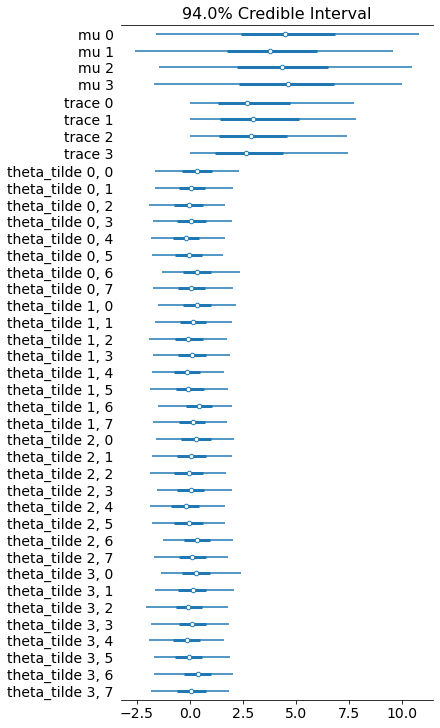

In [10]:
az.plot_forest(data_for_az)